# StockMarketPrediction

## Data Manipulation

### Connecting to Database

In [1]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(create_table_sql, conn):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [2]:
conn = create_connection("normalized_ppg6.db")

In [3]:
def query_table(sql_query, connx=conn):
    testdf = execute_sql_statement(sql_query, connx)
    return(testdf)

### Creating Analytical Dataset

In [4]:
sql_statement = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
query_table(sql_statement)

[('AAPL_5Y',),
 ('AMZN_5Y',),
 ('Company',),
 ('FB_5Y',),
 ('GOOG_5Y',),
 ('HistoricalPrices',),
 ('NFLX_5Y',)]

In [5]:
sql_statement = """CREATE TABLE HistoricalPrices AS
SELECT * FROM
(SELECT 'AAPL' AS StockSymbol, * FROM AAPL_5Y
UNION ALL
SELECT 'AMZN' AS StockSymbol, * FROM AMZN_5Y
UNION ALL
SELECT 'FB' AS StockSymbol, * FROM FB_5Y
UNION ALL
SELECT 'GOOG' AS StockSymbol, * FROM GOOG_5Y
UNION ALL
SELECT 'NFLX' AS StockSymbol, * FROM NFLX_5Y);"""
create_table(sql_statement, conn)

table HistoricalPrices already exists


## Data Exploration

In [6]:
#Importing the Libraries
import numpy as np
from datetime import datetime
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use("fivethirtyeight")
plt.rcdefaults()
plt.rcParams['axes.grid'] = True
from matplotlib.figure import Figure 
fig = Figure()

In [7]:
# Loading Analytical Dataset into a Dataframe

sql_statement = "SELECT * FROM HistoricalPrices;"
tbl_stocks = execute_sql_statement(sql_statement, conn)
stocks_df = pd.DataFrame(tbl_stocks, columns = ['StockSymbol','Date','Open','High','Low','Close','Adj Close','Volume'])

stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
stocks_df.set_index('Date', inplace=True)

### Daily Returns

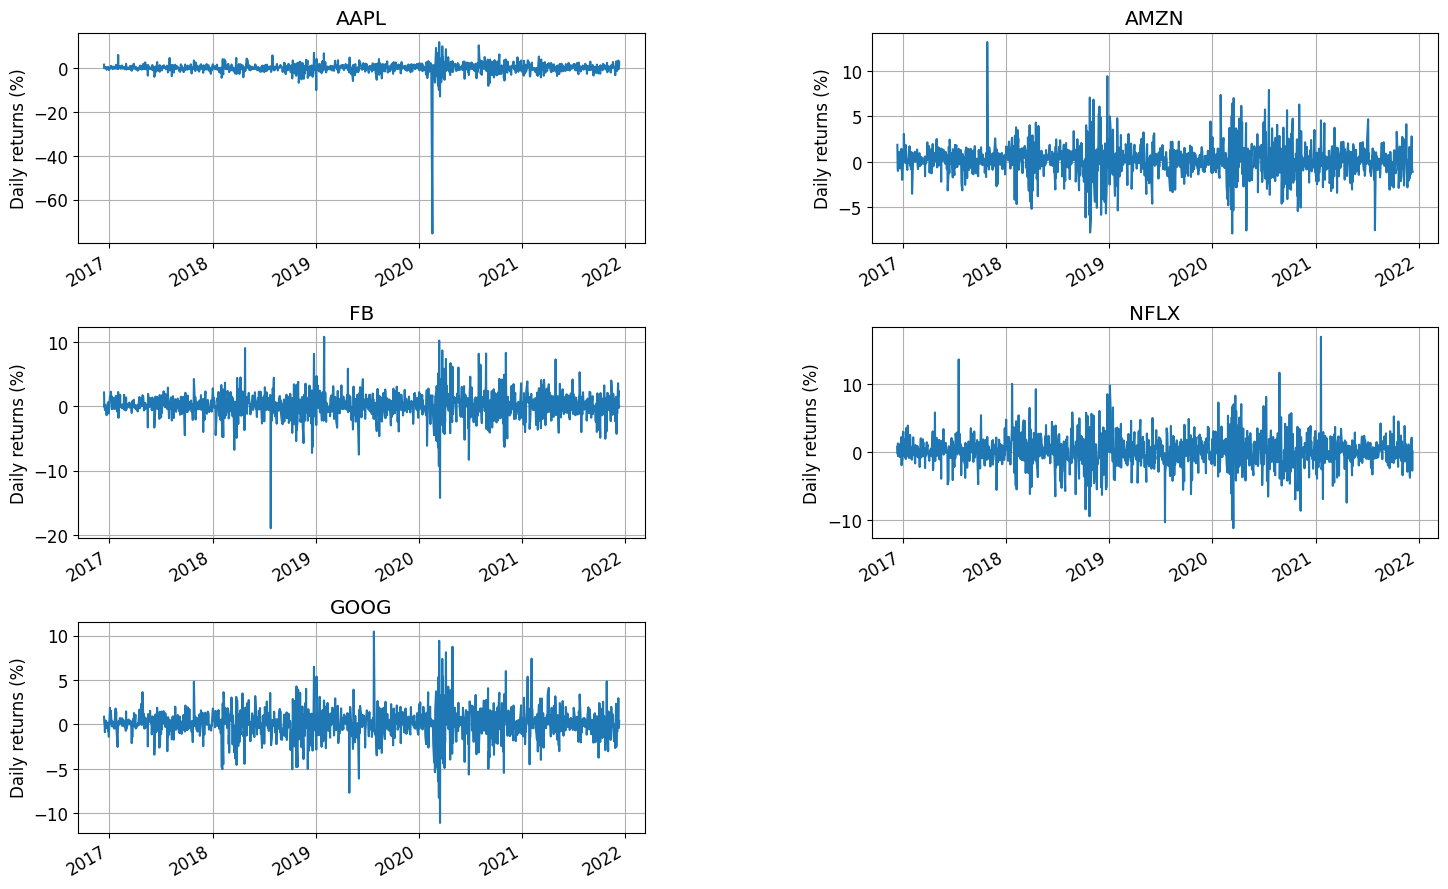

In [8]:
# Caluculate the daily returns for FAANG

returns_df = stocks_df.pivot_table(index=['Date'], columns='StockSymbol', values=['Close'])
returns_df.columns = [col[1] for col in returns_df.columns.values]
returns_df.head()

# Caluculate the percentage of daily returns

FAANG_daily_returns = returns_df.pct_change().dropna()
FAANG_daily_returns_pct = FAANG_daily_returns * 100

company_dict = {1:"AAPL", 2:"AMZN", 3:"FB", 4:"NFLX", 5:"GOOG"}

# plot the daily returns for FAANG
plt.rcParams.update({'font.size': 12})

for i, comp in company_dict.items():
    plt.subplot(3, 2, i)
    FAANG_daily_returns_pct[comp].plot(figsize=(17, 10))
    plt.ylabel('Daily returns (%)')
    plt.xlabel(None)
    plt.title(f"{comp}")

    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

*After looking at the daily returns chart for all 5 companies. we can conclude that the returns are quite volatile and the stock can move about +/- 10% on any given day.*

### Cumulative Returns

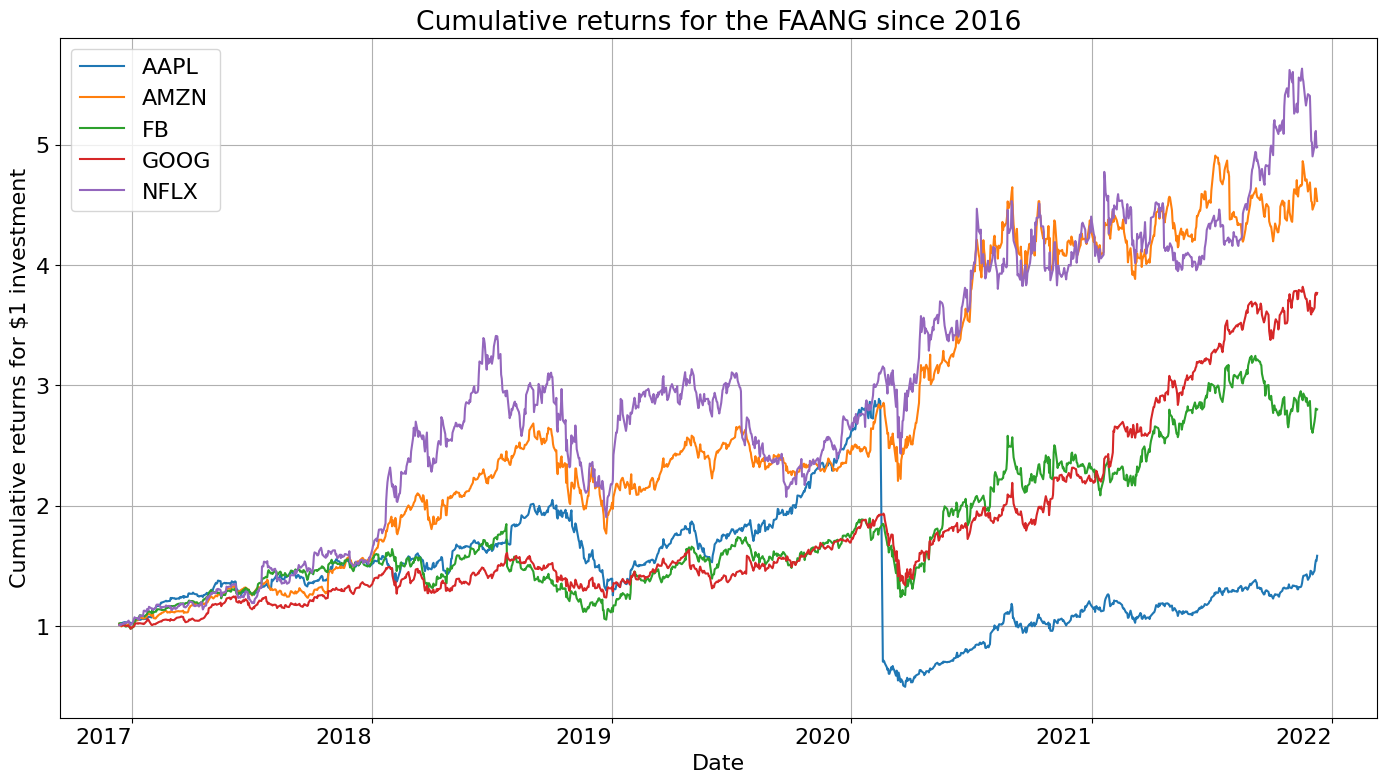

In [9]:
# Calculating the cumulative returns for the FAANG
FAANG_cum_returns = (FAANG_daily_returns + 1).cumprod()

plt.rcParams.update({'font.size': 16})
FAANG_cum_returns.plot(figsize=(17, 10))

plt.title("Cumulative returns for the FAANG since 2016")
plt.ylabel('Cumulative returns for $1 investment')
plt.xticks(rotation=0)

plt.show()

*This chart shows the cumulative returns since 2016 for FAANG. One could have made 6\\$ 𝑜𝑛 𝑎 1\\$ investment in Netflix since 2009. That is quite a remarkable performance.

Not surprisingly, Netflix has had the best returns since 2016. Amazon comes in second. The most surprising result is Apple. It has severely under performed compared to the other stocks in the FAANG group. Apple is currently undervalued and could be the better investment among the FAANG stocks.*

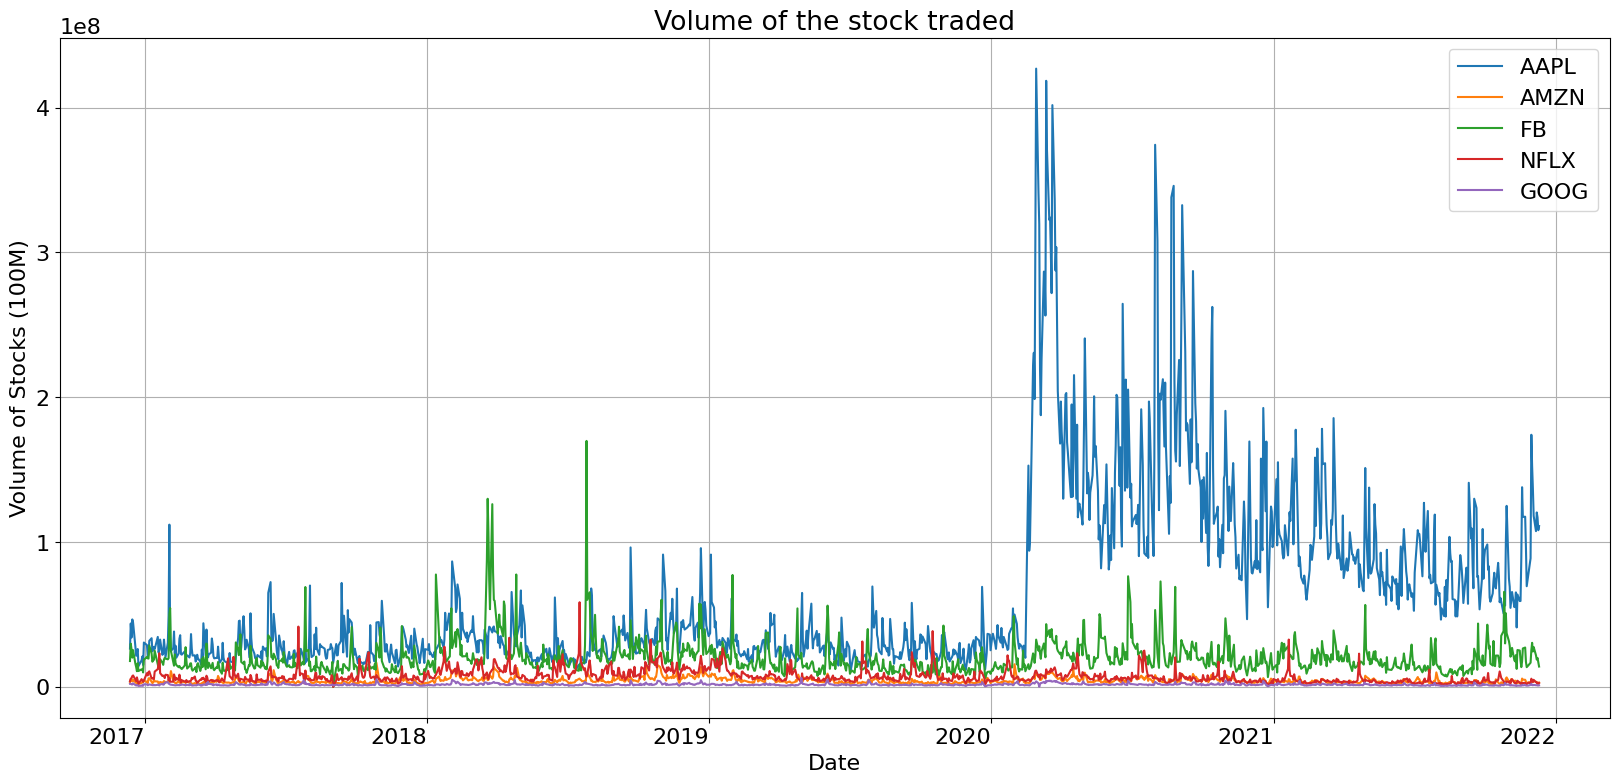

In [10]:
sql_statment = """SELECT tbl_aapl.Date as Date, AAPL, AMZN, FB, NFLX, GOOG  FROM (
(SELECT Date, Volume AS AAPL FROM HistoricalPrices WHERE StockSymbol = 'AAPL')tbl_aapl
INNER JOIN
(SELECT Date, Volume AS AMZN FROM HistoricalPrices WHERE StockSymbol = 'AMZN') tbl_amzn
ON tbl_aapl.Date = tbl_amzn.Date
INNER JOIN
(SELECT Date, Volume AS FB FROM HistoricalPrices WHERE StockSymbol = 'FB') tbl_fb
ON tbl_aapl.Date = tbl_fb.Date
INNER JOIN
(SELECT Date, Volume AS NFLX FROM HistoricalPrices WHERE StockSymbol = 'NFLX') tbl_nflx
ON tbl_aapl.Date = tbl_nflx.Date
INNER JOIN
(SELECT Date, Volume AS GOOG FROM HistoricalPrices WHERE StockSymbol = 'GOOG') tbl_goog
ON tbl_aapl.Date = tbl_goog.Date
)"""

tbl_volume = query_table(sql_statment)
Volume = pd.DataFrame(tbl_volume, columns = ['Date','AAPL','AMZN','FB','NFLX','GOOG'])
Volume['Date'] = pd.to_datetime(Volume['Date'])
Volume.set_index('Date', inplace=True)

plt.rcParams.update({'font.size': 16})

Volume.plot(figsize = (20,10))
plt.title(f"Volume of the stock traded")
plt.ylabel('Volume of Stocks (100M)')
plt.xticks(rotation=0)

plt.show()

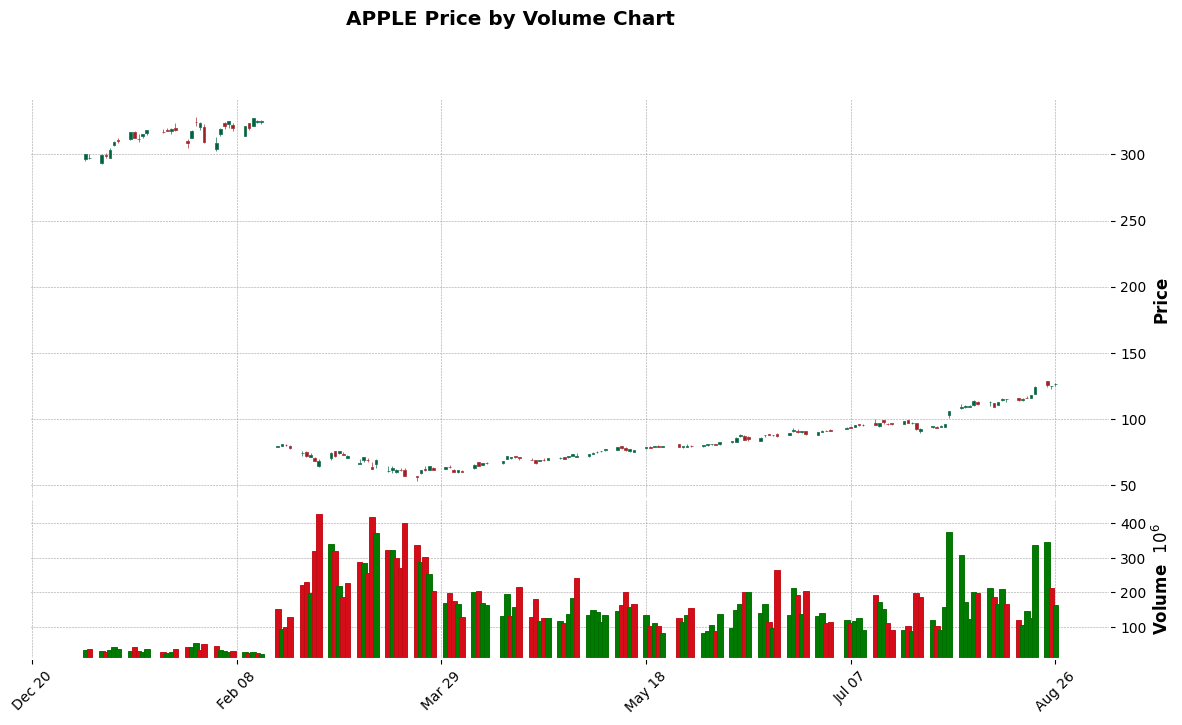

In [11]:
#Volume traded for Apple between Dec 2019 and Aug 2020
import mplfinance as mpf

df_AAPL = stocks_df[stocks_df['StockSymbol'] == 'AAPL']
dt_range = (datetime(2020,1,1), datetime(2020,8,26))

df_AAPL = pd.DataFrame(df_AAPL[dt_range[0]:dt_range[1]])
mpf.plot(df_AAPL, volume=True, type = 'candle', show_nontrading=True,
         style='charles', title='APPLE Price by Volume Chart', figsize = (15,8))

*Volume is the number of shares of a stock that have changed hands over a certain period of time. 
Stocks with higher volumes have more investors interested in buying or selling them. 
If a stock has a high volume and the price is rising, it's easier to sell it at a desirable price.*

*Trading volume can help an investor to identify momentum in stocks and confirm a trend. 
If trading volume increases, prices generally move in the same direction.*

**_The above Graph shows the volume traded by companies which clearly shows that stocks of Apple are traded more compared to other company stocks in recent years and in feb 2020 and 
it reached it's peak_**

C:\Users\iamh2k\AppData\Local\Temp/ipykernel_15836/4210286462.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company[column_name] = company['Adj Close'].rolling(ma).mean().dropna()


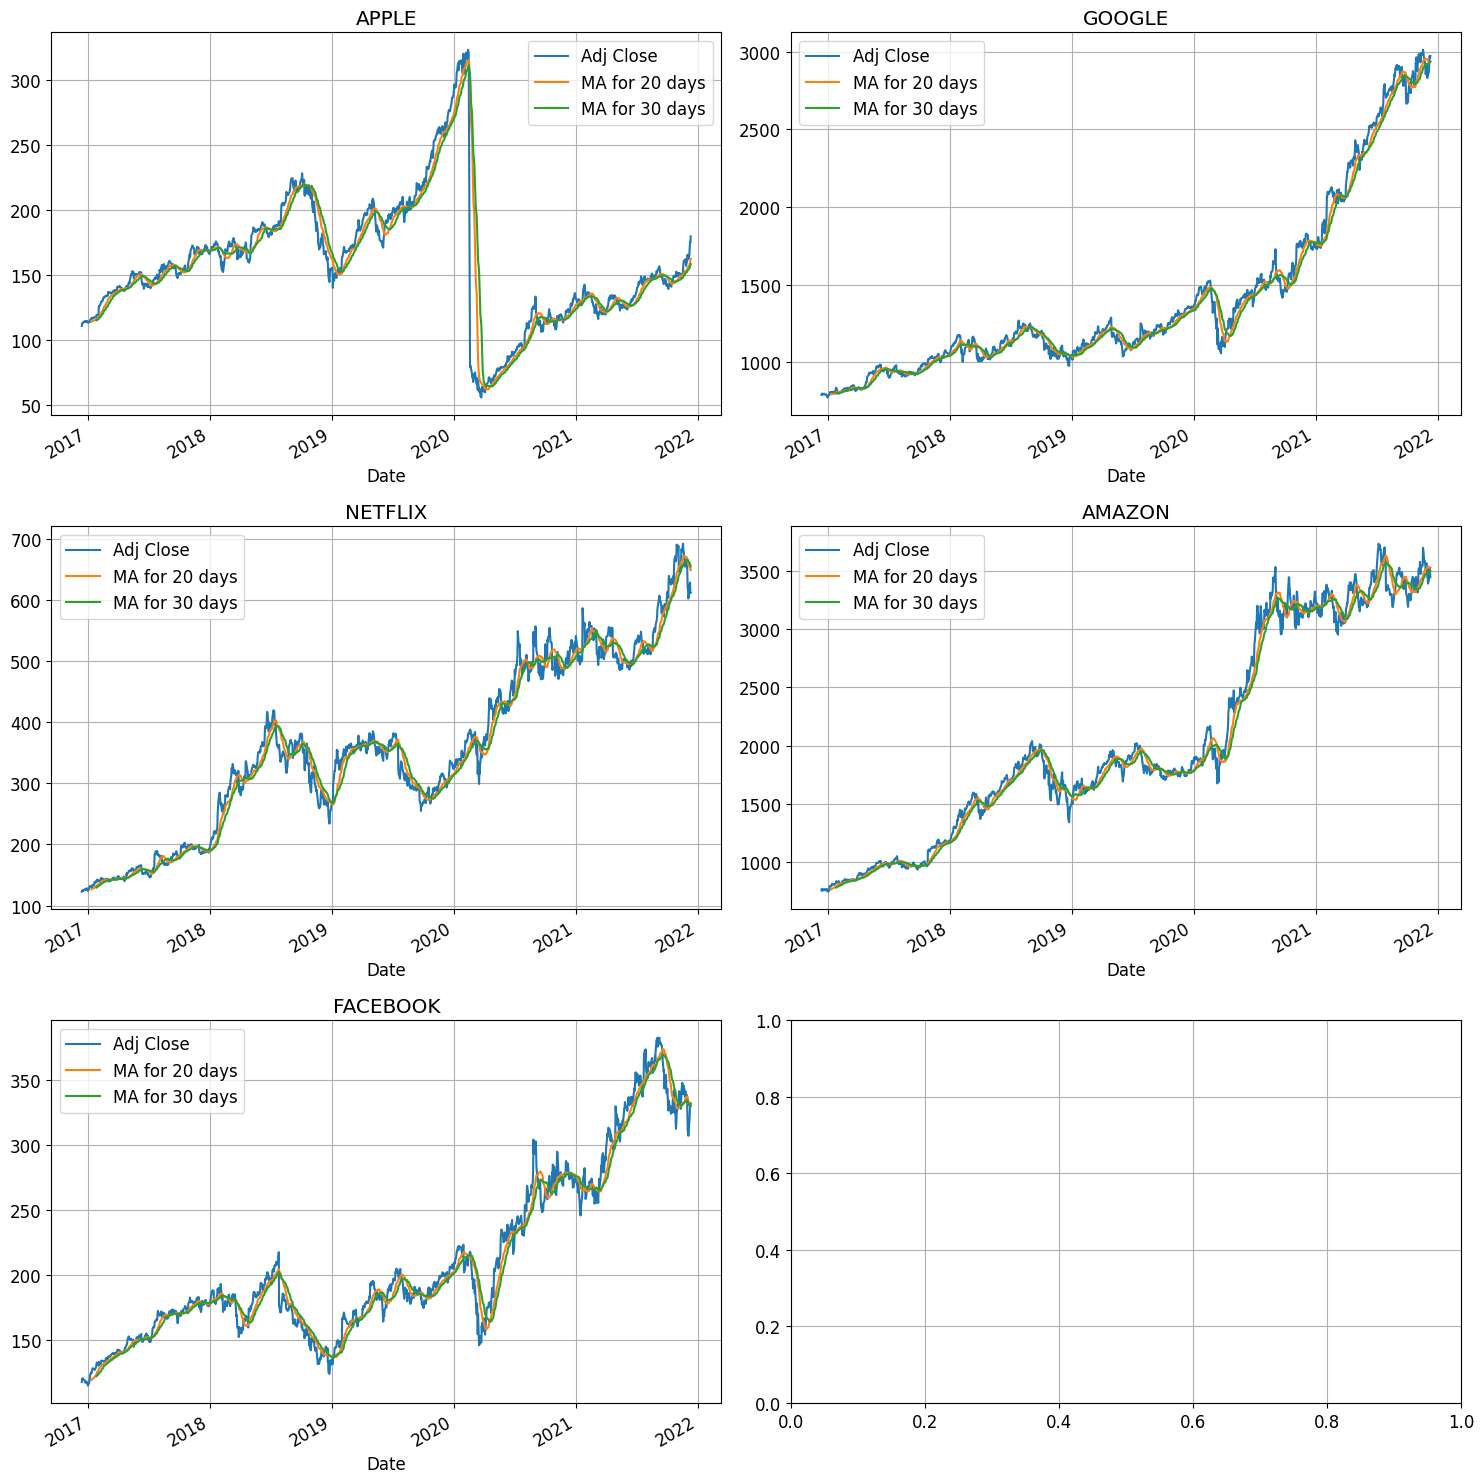

In [12]:
# The moving average of the various stocks

AdjClose = stocks_df[['StockSymbol', 'Adj Close']].copy()

for symbol in AdjClose.StockSymbol.unique():
    globals()[f'df_{symbol}'] = AdjClose[AdjClose['StockSymbol'] == symbol]

company_list = [df_AAPL, df_AMZN, df_FB, df_NFLX, df_GOOG]  

ma_days = [20, 30]
for company in company_list:
    for ma in ma_days:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean().dropna()

plt.rcdefaults()
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

df_AAPL[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

df_AMZN[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

df_FB[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[2,0])
axes[2,0].set_title('FACEBOOK')

df_NFLX[['Adj Close', 'MA for 20 days', 'MA for 30 days']].plot(ax=axes[1,0])
axes[1,0].set_title('NETFLIX')

df_GOOG[['Adj Close','MA for 20 days', 'MA for 30 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

fig.tight_layout()
plt.show()

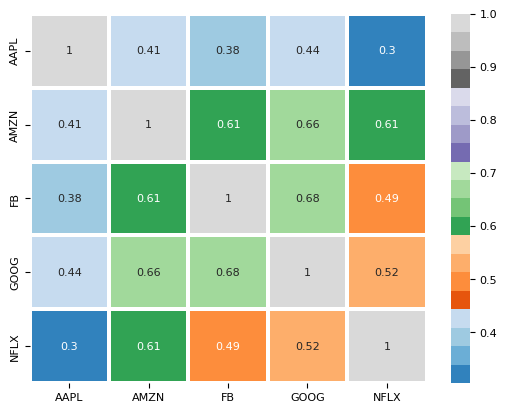

In [13]:
# Calculate the stock correlation matrix
import seaborn as sns

plt.rcParams.update({'font.size': 8})
sns.heatmap(FAANG_daily_returns.corr(), annot=True, cmap='tab20c', linewidths=1.5)
fig.tight_layout()

 4


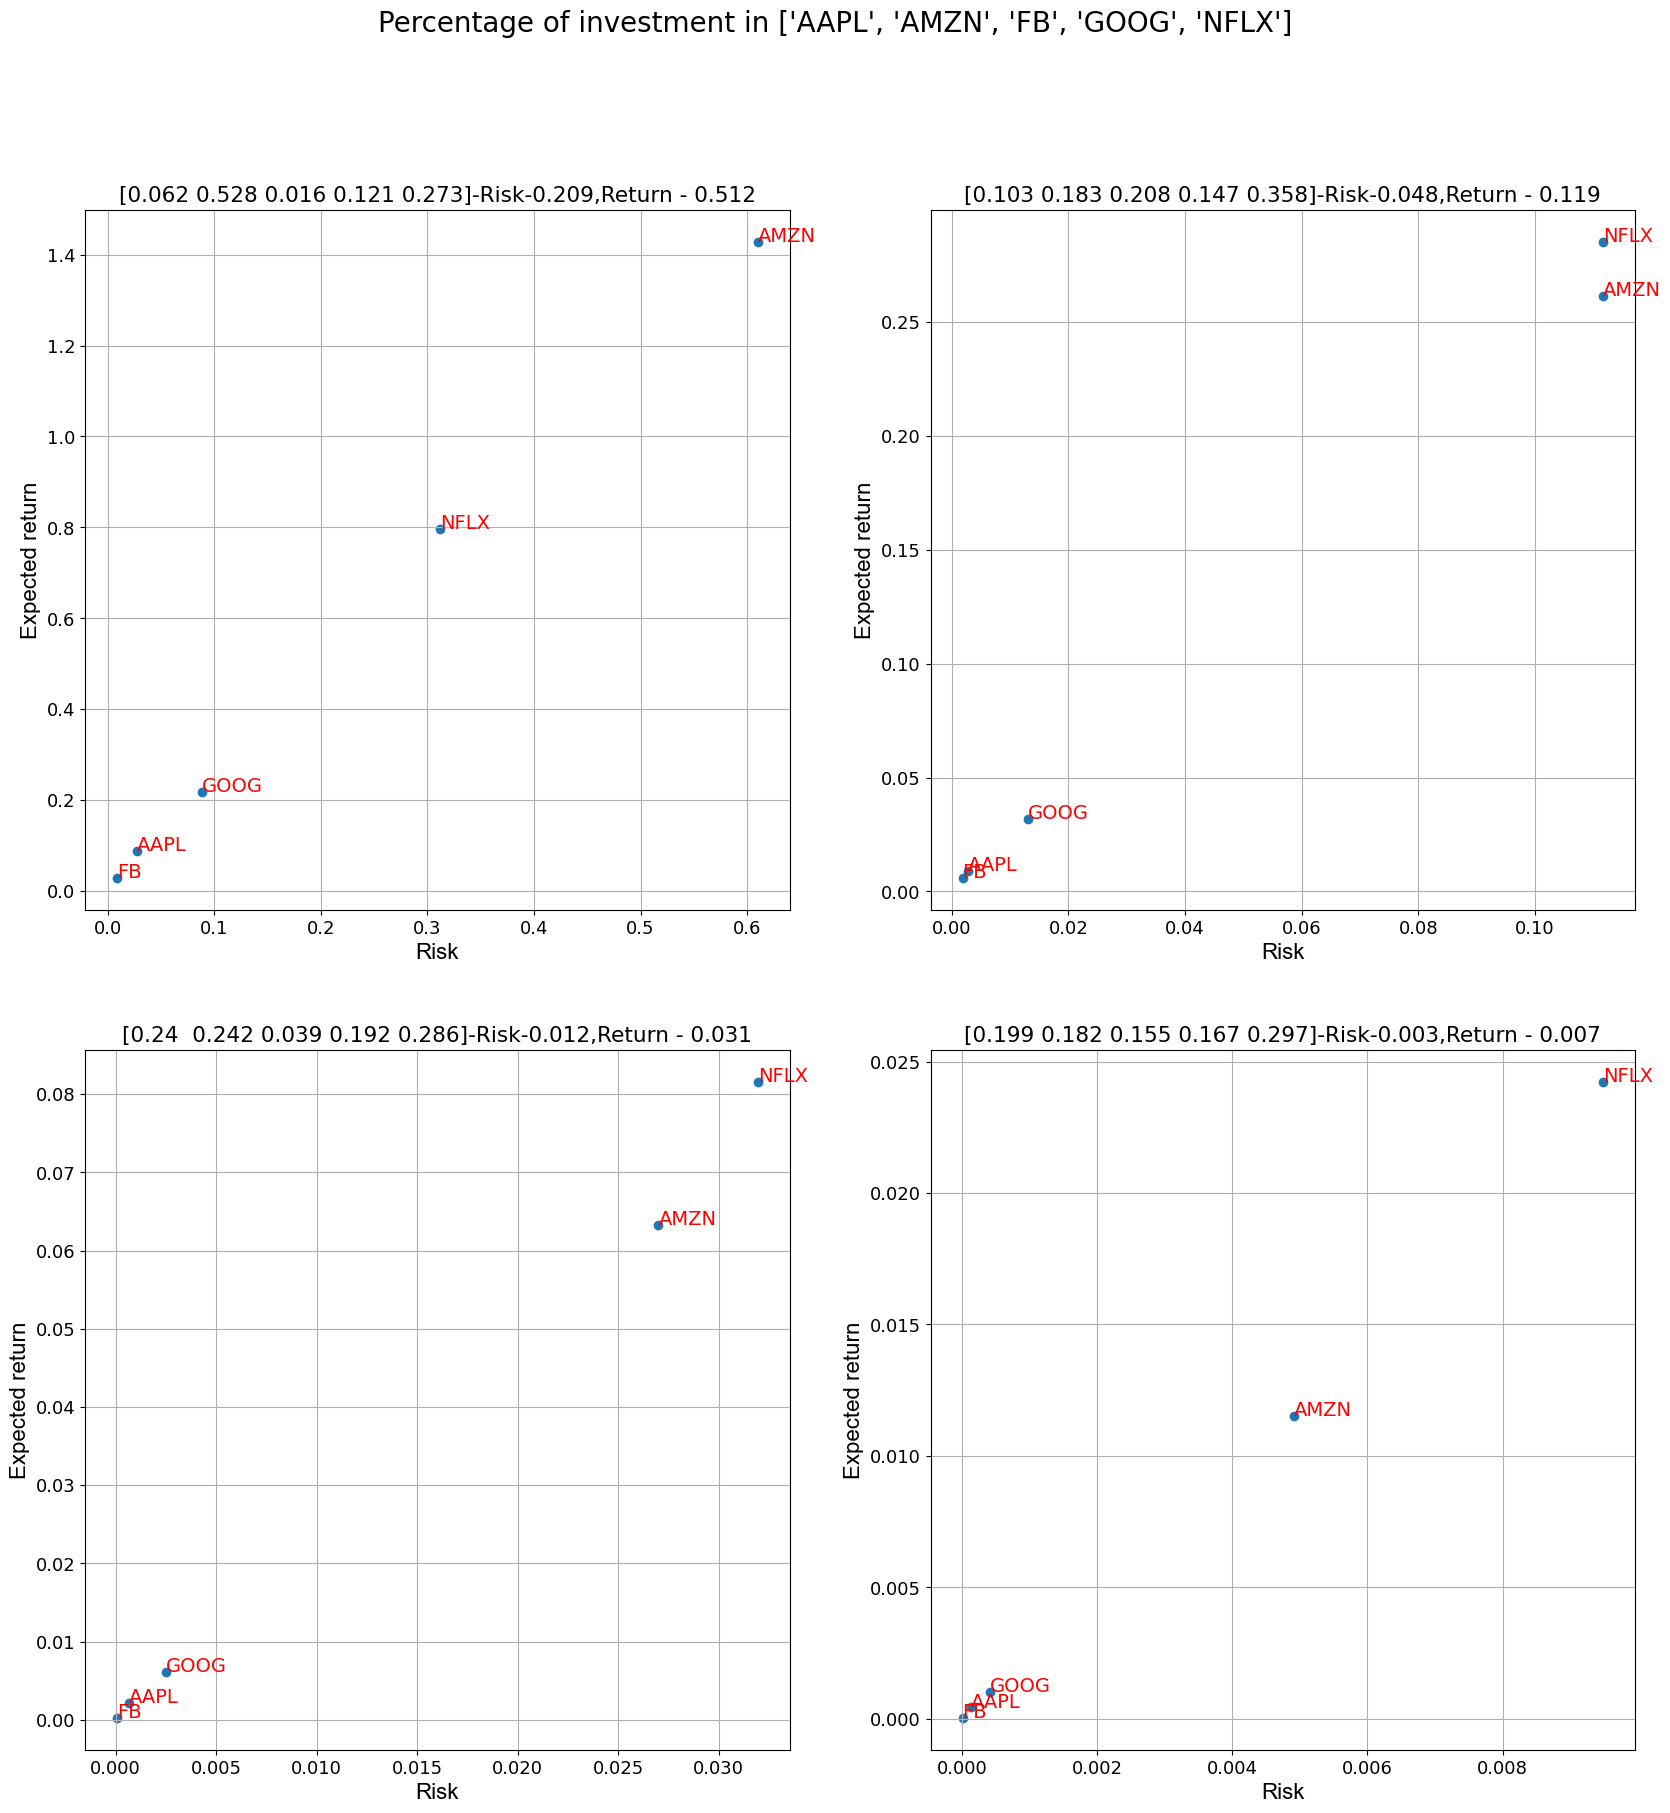

In [14]:
# Caluculating the Risk and Returns for Stocks with different percentages of investment

returns_val = returns_df/returns_df.iloc[0]
lis = list(returns_val.columns)
invest_list = []
no_of_sets = int(input())

# Add a way to user-provided percentage #hemanth
# Generating the random percentages of investment in FAANG
for i in range(no_of_sets):
    pct_investment = np.random.random(5)
    pct_investment /= pct_investment.sum()
    invest_list.append(pct_investment.round(3))

# plot the risk and returns of each portfolio
plt.rcParams.update({'font.size': 13})
plt.subplots(figsize=(20,20))
XY_label = {'family': 'arial', 'color': 'black', 'size': 16}
plt.suptitle(f'Percentage of investment in {list(returns_val.columns)}',fontsize=20)

for i in range(no_of_sets):
    returns_val = returns_val * invest_list[i]
    plt.subplot(int((no_of_sets)/2),2,i+1)
    plt.grid(True)
    plt.scatter(returns_val.std(),returns_val.mean())
    plt.xlabel('Risk', fontdict = XY_label)
    plt.ylabel('Expected return',fontdict = XY_label)
    plt.title(f'{invest_list[i]}-Risk-{(((returns_val.std().sum())/5).round(3))},Return - {(((returns_val.mean().sum())/5).round(3))}')
    for i in range(5):
        plt.text(returns_val.std()[i],returns_val.mean()[i],returns_val.columns[i],color = 'red',size = 14)

## Time-Series Analysis

### Exploring Time Components

In [15]:
import os
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 10})
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

*For our time series analysis, we only need the close price at daily level. So for a particular chosen company (AMZN), we will run the detailed analysis. At the end of the analysis, we will functionalize the analysis to be easily applied for any chosen stock.*

In [16]:
tbl_close = query_table("""SELECT Date, Close FROM HistoricalPrices 
WHERE StockSymbol='AMZN' """)

df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)
display(df_close)

,Close
Date,
2016-12-12,760.119995
2016-12-13,774.340027
2016-12-14,768.820007
2016-12-15,761.000000
2016-12-16,757.770020
...,...
2021-12-06,3427.370117
2021-12-07,3523.290039
2021-12-08,3523.159912


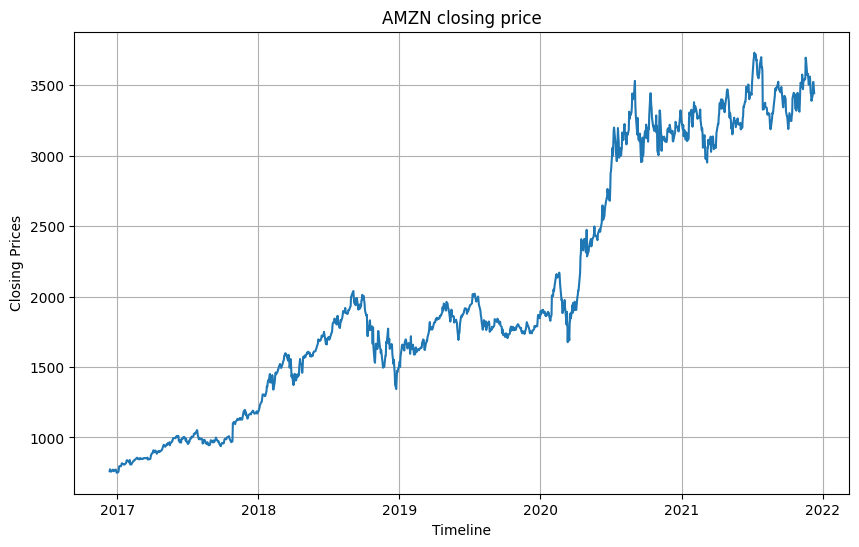

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df_close['Close'])
plt.title('AMZN closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

We can observe a clear upward trend in the price over time, yet no noticeable yearly pattern. We will look for any significant seasonality further and model accordingly.

<Figure size 1000x600 with 0 Axes>

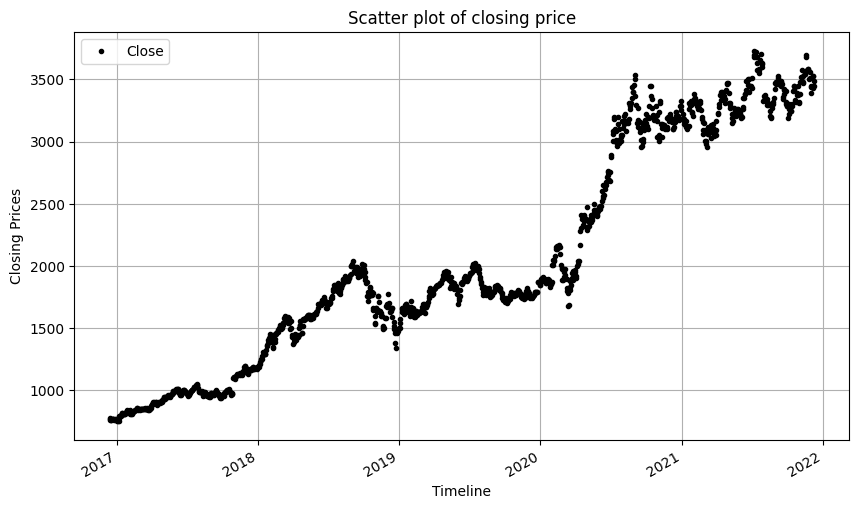

In [18]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

Towards the beginning of 2020, we can see some significant volatility, which can attributed to increase in online shopping during covid lockdown period. We can see a significant growth for Amazon stock value in otherwise unfortunate time.

<Figure size 1000x600 with 0 Axes>

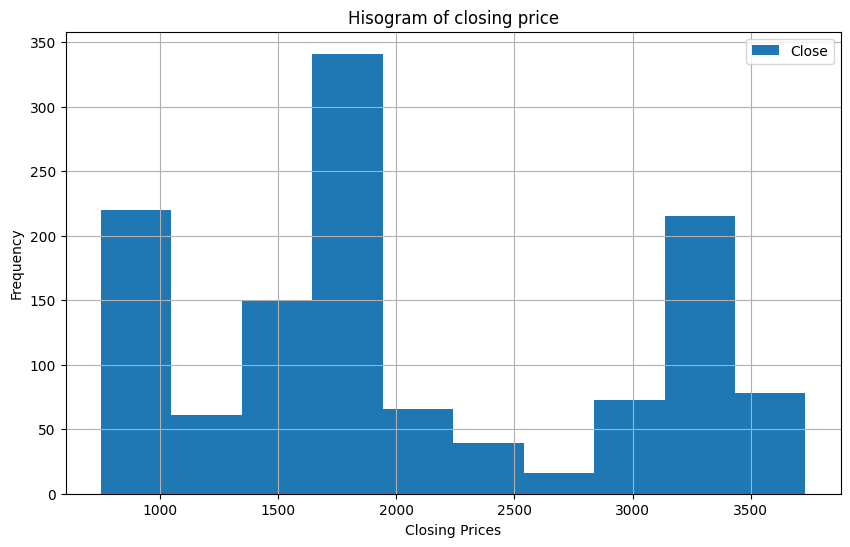

In [19]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.xlabel('Closing Prices')
plt.show()

We can see two peaks in the closing price and a huge trough between the two, due to sudden jump in price in 2020. 

#### Testing For Stationarity:

First, we need to check if our data series is stationary or not, because time series analysis only works with stationary data (time-independent).

For this, we will use Augmented Dickey-Fuller (ADF) Test. It can help us determine if there is a unit root ($\alpha$ = 1) in our time series, which will result in non-stationarity. In ADF test, we check if the coefficient of the Y<sub>t-1</sub> is 1 or not and take corrective action if sationarity is not confirmed. 

Ho: It is non-stationary ($\alpha$ = 1)

H1: It is stationary

In [20]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output[f'critical value ({key})'] =  values
    print(output)


test_stationarity(df_close)

Test Statistics                  -0.643743
p-value                           0.860788
No. of lags used                  3.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


`Inference: p-value (0.86) is greater than 0.05, so we cannot reject the Null hypothesis and the series is almost completely non-stationary`

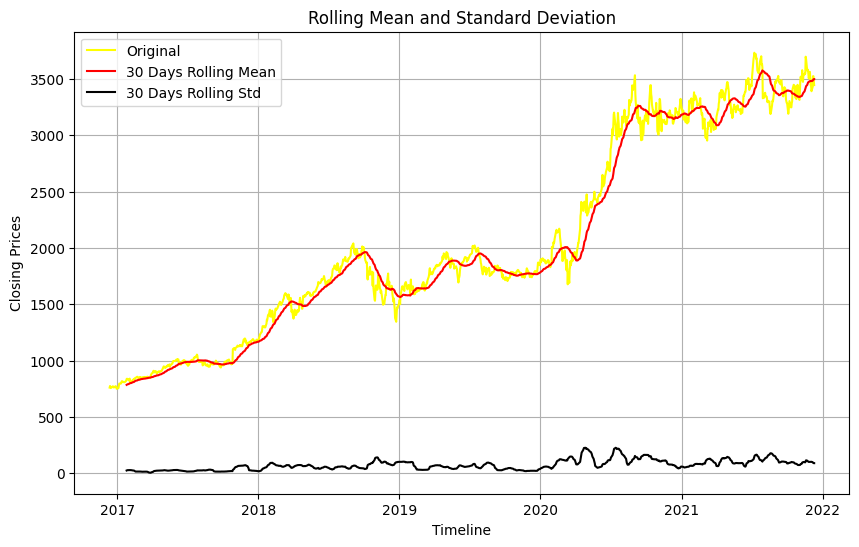

In [21]:
def moving_avgstd(timeseries, window_size=30):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd = timeseries.rolling(window_size).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label=f'{window_size} Days Rolling Mean')
    plt.plot(rolstd, color='black', label =f'{window_size} Days Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.show(block=False)

moving_avgstd(df_close['Close'])

If both mean and standard deviation are flat lines (constant mean and constant variance), the series becomes stationary.

To understand the non-stationarity, we will take a look at Trend and Seasonality components within the time series

<Figure size 1000x600 with 0 Axes>

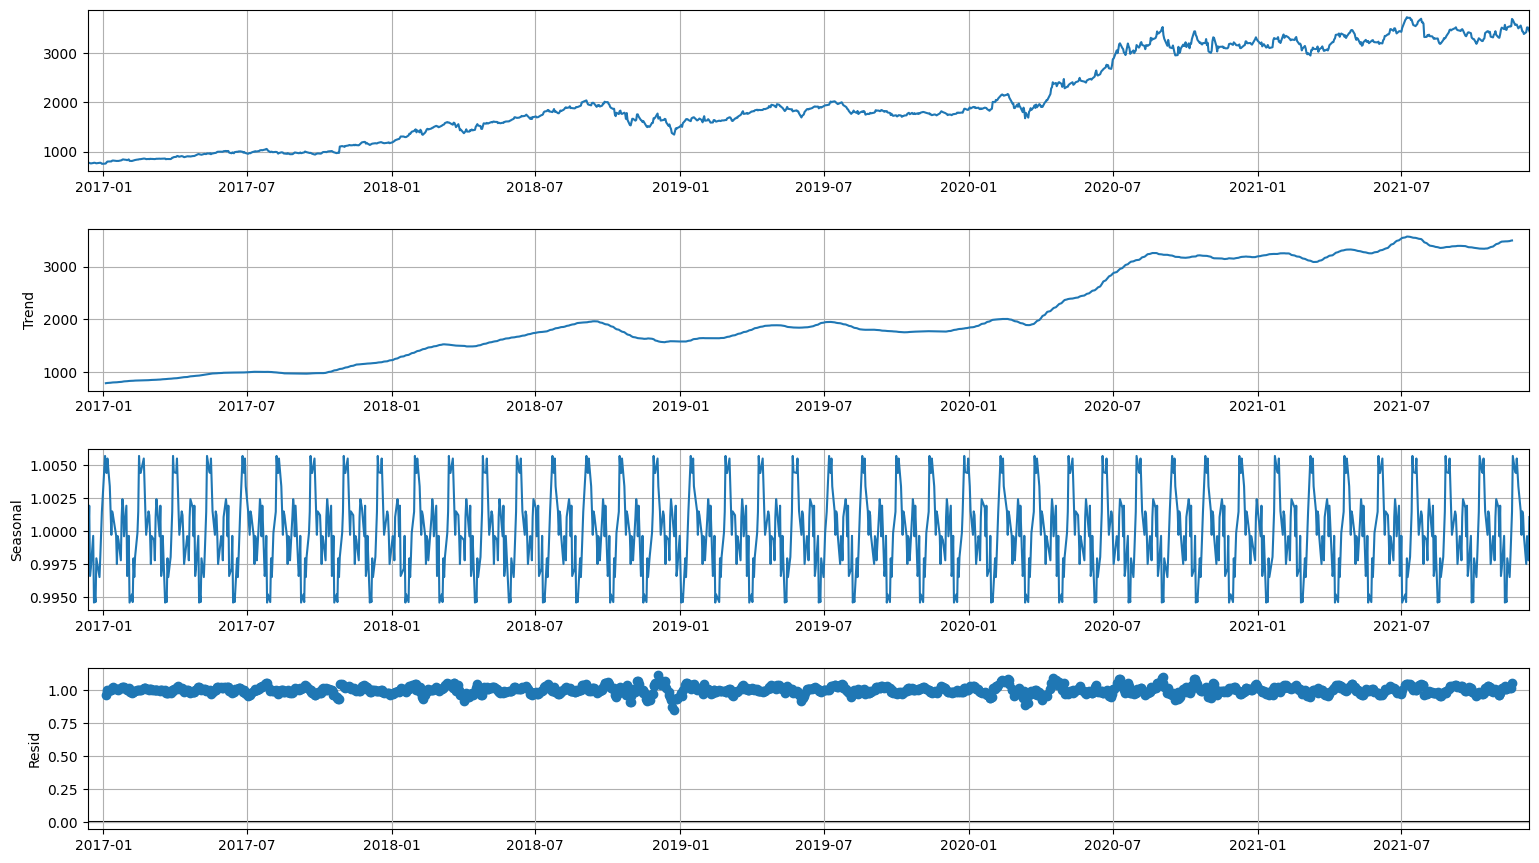

In [22]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

plt.show()

We can see the seasonality component is a steady narrow pattern and does not impact the price as much as the general trend of the data.

One method for transforming such simplest non-stationary data is differencing. This process involves taking the differences of consecutive observations.

In [23]:
df_close['diff_1'] = df_close['Close'].diff(periods=1)

In [24]:
test_stationarity(df_close['diff_1'].dropna())

Test Statistics                 -22.346137
p-value                           0.000000
No. of lags used                  2.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


*__P Value of 0 supports our Alternate Hypothesis that our data series is now Stationary__*

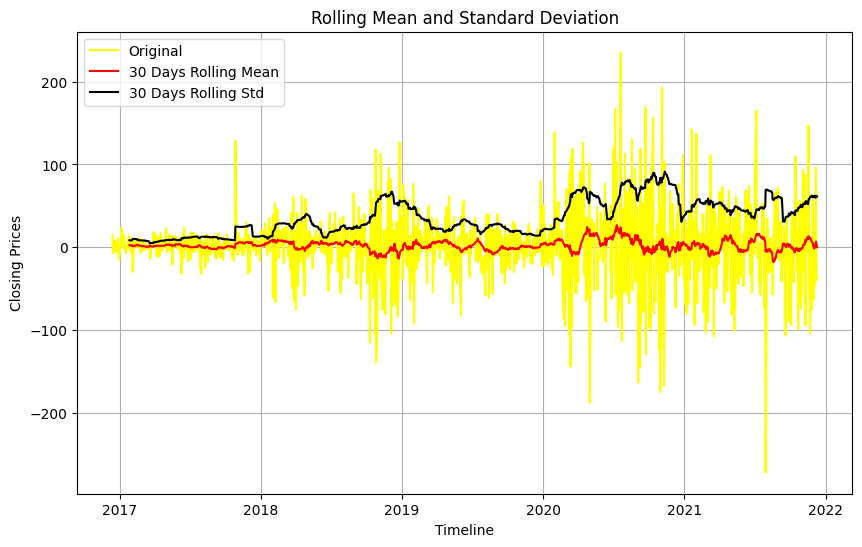

In [25]:
moving_avgstd(df_close['diff_1'])

 Now we can see a near flat moving average and std. deviation which confirm the stationarity

### ARIMA Modeling

#### Training:

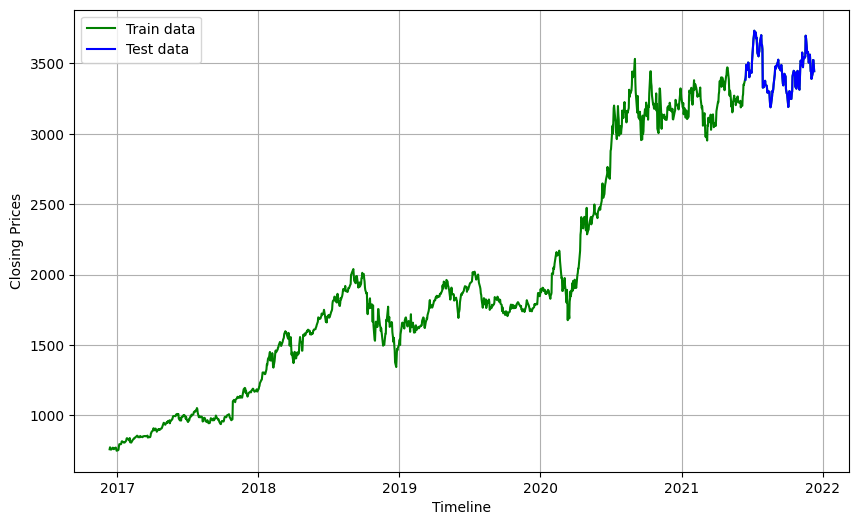

In [26]:
#split data into train and training set
split_ratio = 0.9
train_len = int(len(df_close)*split_ratio)
train_data, test_data = df_close[:train_len], df_close[train_len:]
# Seperating diff_1 series and excluding first null value
train_diff, test_diff = train_data['diff_1'][1:], test_data['diff_1'][1:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.plot(df_close['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()
plt.show()

In [27]:
def arimamodel(timeseries):
    # Buids and auto arima model that will find the most suitable p,d,q values
    automodel = auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf", # use adftest to find optimal 'd'
                              seasonal=True, # No Seasonality
                              trace=True)
    return automodel

In [28]:
def reverse_diff(series, start_val=0, order=1):
    # Swaps diff values back to true prices
    series = np.insert(series, 0, start_val)
    result = series.cumsum()[1:]
    
    return result

In [29]:
def plot_arima(n_periods, timeseries, automodel, test_series=None, past_periods=None, true_price=None):
    # Makes a forecast for n periods and plots them
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    
    if true_price:
        fc = reverse_diff(fc, start_val=true_price)
        confint[:, 0] = confint[:, 0] + true_price
        confint[:, 1] = confint[:, 1] + true_price
        # confint[:, 0] = reverse_diff(confint[:, 0], start_val=true_price)
        # confint[:, 1] = reverse_diff(confint[:, 1], start_val=true_price)
    
    # Business Day index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="B")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    if past_periods:
        timeseries = timeseries[-past_periods:]
    plt.plot(timeseries, label="Past Data")
    if test_series is not None:
        plt.plot(test_series, color='blue', label='Actual Stock Price')
    plt.plot(fc_series, color='red', label ='Predicted Stock Price')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25,
                    label ="95% confidence interval")
    plt.legend(loc='upper left')
    plt.show()

In [30]:
def score_arima(n_periods, test_timeseries, automodel, true_price=None):
    # Generates predictions and compares with test data and measures error metrics
    fc = automodel.predict(n_periods=n_periods)
    
    if true_price:
        fc = reverse_diff(fc, true_price)
    
    #print(fc.shape, test_timeseries.shape)
    
    mse = mean_squared_error(test_timeseries, fc)
    print(f'MSE: {mse}')
    mae = mean_absolute_error(test_timeseries, fc)
    print(f'MAE: {mae}')
    rmse = math.sqrt(mean_squared_error(test_timeseries, fc))
    print(f'RMSE: {rmse}')
    test_timeseries = test_timeseries.values
    mape = np.mean(np.abs(test_timeseries - fc)/np.abs(test_timeseries))
    print(f'MAPE: {mape} ({mape:.2%})')
    
    return None

In [31]:
automodel = arimamodel(train_data['Close'])
print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11569.417, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11571.927, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11569.866, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11569.890, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11573.708, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11571.399, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11571.392, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11571.891, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11571.823, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11569.793, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11571.494, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.084 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 1 respectively.

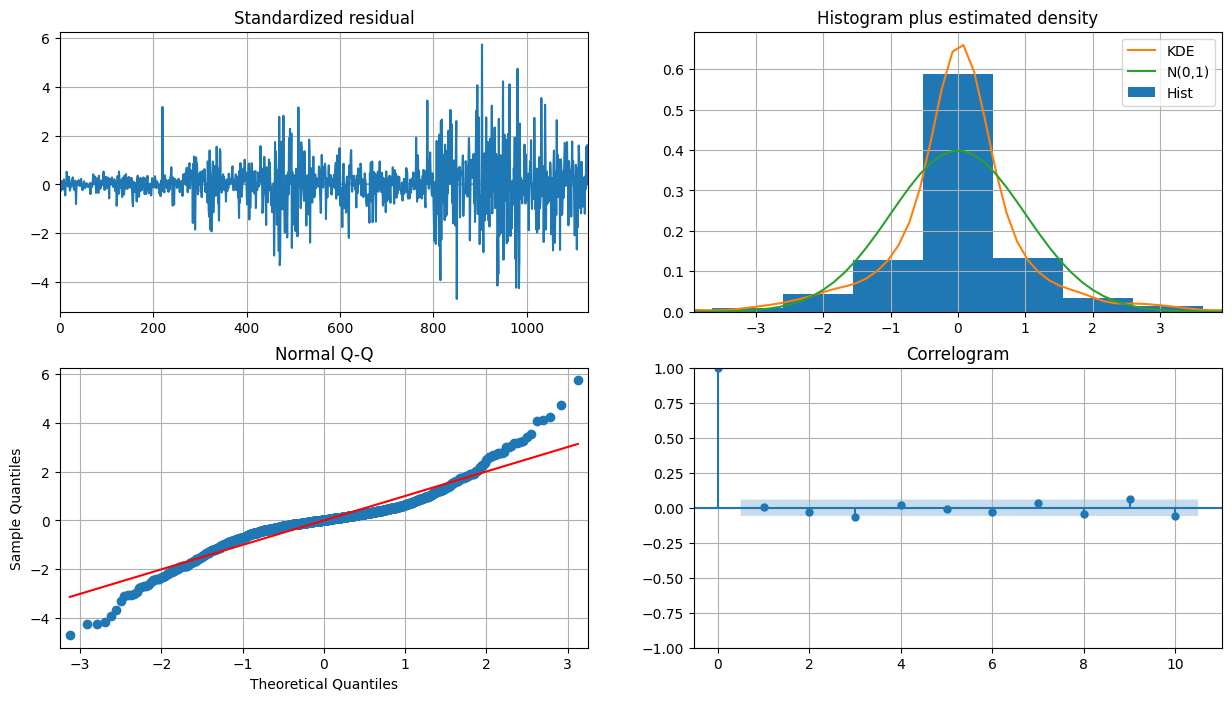

In [32]:
automodel.plot_diagnostics(figsize=(15,8))
plt.show()

Plot Diagnostics: tells us if the model met the prerequisites to be considered a good fit.

Top left: *The residual errors seem to fluctuate around a mean of zero and have a uniform variance despite the heavy spread at the end.*

Top Right: *The density plot suggest normal distribution with mean zero.*

Bottom left: *All the dots should fall well in line with the red line. Any significant deviations would imply the distribution is skewed.*

Bottom Right: *The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.*

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

#### Testing:

In [33]:
def start_price(timeseries):
    start_price = timeseries['Close'][0]
    return start_price

def last_price(timeseries):
    start_price = timeseries['Close'][-1]
    return start_price

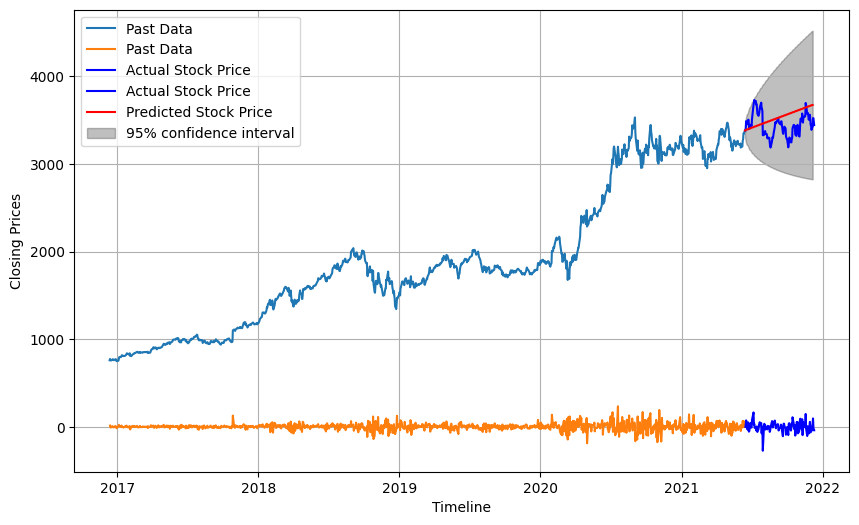

In [34]:
plot_arima(126, train_data, automodel, test_series=test_data)

#### Model Performance:

In [35]:
score_arima(len(test_data), test_data['Close'], automodel)

MSE: 33832.93971579712
MAE: 160.4473770674018
RMSE: 183.93732551006912
MAPE: 0.04702397472962692 (4.70%)


Around 4.7% MAPE(Mean Absolute Percentage Error) implies the model is about 95.7% accurate in predicting the test set observations.

### Price Forecasting:

Using the above fitted model, now we can forecast the stock price for next month (100 Business days)

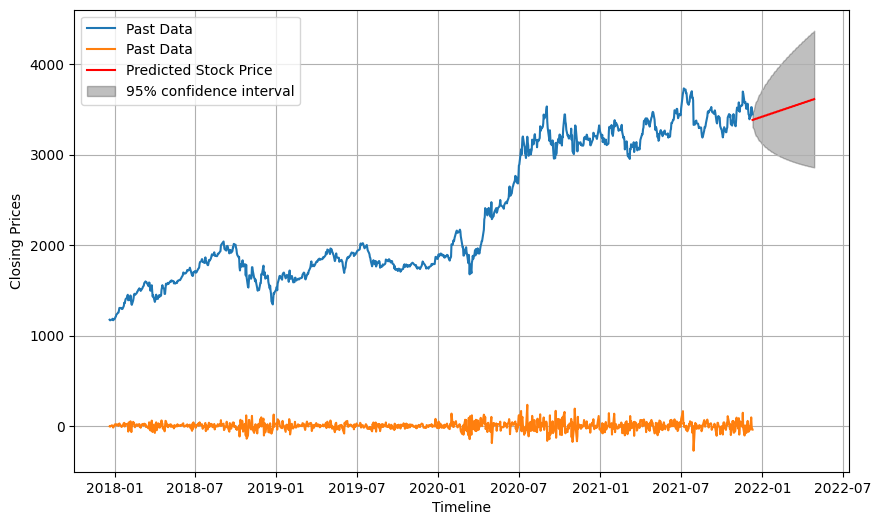

In [36]:
plot_arima(100, df_close, automodel, past_periods=1000)

#### Appendix:

In [37]:
def closeprice_data(company_symbol):
    tbl_close = query_table(f"""SELECT Date, Close FROM HistoricalPrices 
        WHERE StockSymbol='{company_symbol}' """)

    df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
    df_close['Date'] = pd.to_datetime(df_close['Date'])
    df_close.set_index('Date', inplace=True)
    #display(df_close)
    return (df_close)

In [38]:
def generalized_arima(n_periods, symbol, past_days=None):
    timeseries = closeprice_data(symbol)
    glamodel = arimamodel(timeseries)
    plot_arima(n_periods, timeseries, glamodel, past_periods=past_days)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9150.516, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9156.783, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9148.520, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9148.615, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9157.027, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9150.518, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9152.519, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9149.202, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.541 seconds


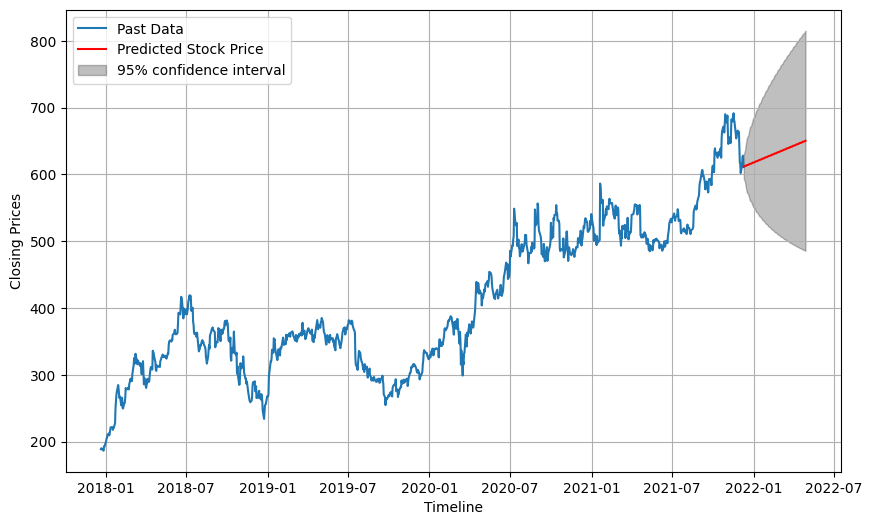

In [39]:
generalized_arima(100, 'NFLX', past_days=1000)